# Mesh Study of Huygen's Surface

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import scienceplots

In [2]:
# Set logging level to ERROR to reduce output verbosity
td.config.logging_level = "ERROR"

## Initialization

In [3]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.1, wvl_max=1.6)
N = 301 # num_points

In [4]:
# 1 Computational domain size
h = 0.220  # Height of cylinder
spc = 2
Lz = spc + h + h + spc

Px = Py = P = 0.666 # periodicity
sim_size = [Px, Py, Lz]

In [5]:
# 3 Structures
r = 0.242  # radius of the cylinder
n_Si = 3.5
Si = td.Medium(permittivity=n_Si**2, name='Si')
cylinder = td.Structure(
    geometry=td.Cylinder(center=[0, 0, h / 2], radius=r, length=h, axis=2), medium=Si
)

# Spin_on glass + substrate
n_glass = 1.4
n_SiO2 = 1.45
glass = td.Medium(permittivity=n_glass**2, name='glass')
SiO2 = td.Medium(permittivity=n_SiO2**2, name='oxide')

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=SiO2,
    name='substrate'
)

glass = td.Structure(
    geometry=td.Box(
        center=(0,0,Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=glass,
    name='superstrate'
)

# Polymer
n_polymer = 1.66
polymer = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(td.inf,td.inf,td.inf)
    ),
    medium=td.Medium(permittivity=n_polymer**2, name='polymer'),
    name='polymer'
)

In [6]:
# 6 Run Time
bandwidth = fr.fmax - fr.fmin
run_time= 50 / bandwidth

In [7]:
# 7 Boundary Condition
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

## Mesh Study Loop Assignment

In [8]:
dls = [P/2, P/4, P/8, P/16, P/32, P/64] # mesh study list
sims = {}

In [9]:
for i, dl in enumerate(dls):
    # 2 Grid Specifications
    horizontal_grid = td.UniformGrid(dl=dl)
    vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
    grid_spec=td.GridSpec(
        grid_x=horizontal_grid,
        grid_y=horizontal_grid,
        grid_z=vertical_grid,
    )

    # 4 Sources
    source = td.PlaneWave(
        source_time=fr.to_gaussian_pulse(),
        size=(td.inf, td.inf, 0),
        center=(0, 0, Lz/2 - spc + 2 * dl),
        direction="-",
        pol_angle=0
    )

    # 5 Monitor
    monitor = td.FluxMonitor(
        center=(0, 0, -Lz/2 + spc - 2*dl),
        size=(td.inf, td.inf, 0),
        freqs=fr.freqs(N),
        name="flux"
    )

    sim_empty=td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, glass],
        sources=[source],
        monitors=[monitor],
        run_time=run_time,
        boundary_spec=bc
    )

    sim_actual = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, glass, cylinder],
        sources=[source],
        monitors=[monitor],
        run_time=run_time,
        boundary_spec=bc
    )

    sims[f"norm{i}"] = sim_empty
    sims[f"actual{i}"] = sim_actual  
    

In [10]:
# verify the sims dictionary
print(sims.keys())
batch = web.Batch(simulations=sims, verbose=True)

dict_keys(['norm0', 'actual0', 'norm1', 'actual1', 'norm2', 'actual2', 'norm3', 'actual3', 'norm4', 'actual4', 'norm5', 'actual5'])


In [ ]:
# run the simulations
batch_data = batch.run(path_dir="data")

Output()

18:29:42 EDT Started working on Batch containing 12 tasks.

18:29:51 EDT Maximum FlexCredit cost: 0.300 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

18:29:57 EDT Batch complete.

Output()

## Plotting

In [12]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])

In [ ]:
x = td.C_0 / fr.freqs(N) * 1000
Ts = []
for i in range(len(dls)):
    Ts.append(batch_data[f"actual{i}"]["flux"].flux / batch_data[f"norm{i}"]["flux"].flux)

plt.figure(figsize=(12, 5))
for i, T in enumerate(Ts):
    plt.plot(x, T, "-",lw=1, label=f"dl={dls[i] * 1000:.1f} nm")
plt.xlabel(r"Wavelength [$nm$]", fontsize=12)
plt.ylabel("Magnitude", fontsize=12)
plt.xlim(1100, 1600)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=10) # change tick label size to 10
plt.title("Transmission Spectra with Different Mesh Sizes", fontsize=14)
plt.savefig("mesh_convergence.png", dpi=300)
plt.show()

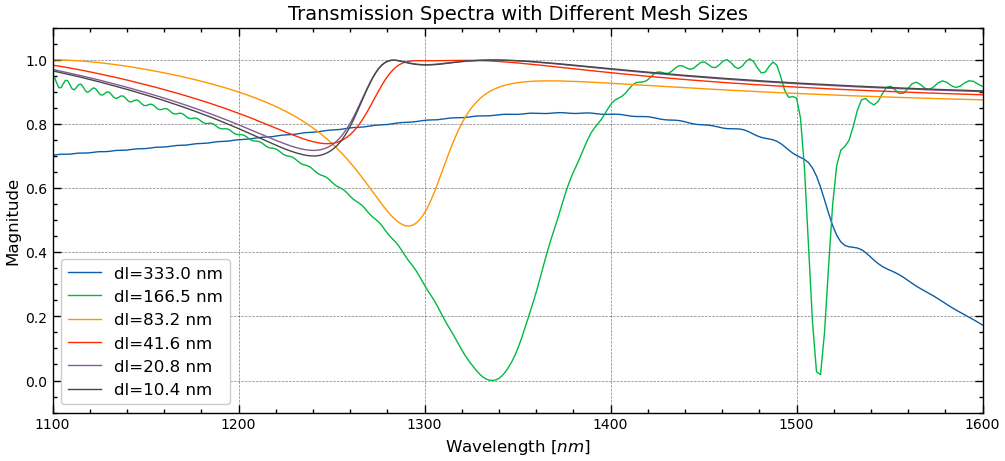